In [2]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn_image as isns
import IPython

from trainer import ProsodyAttentionTrainer, ProsodyDistillationTrainer
from dataset.inference import SLURPProsodyDataset

def smooth(x):
    kernel = torch.FloatTensor([[[0.006, 0.061, 0.242, 0.383, 0.242, 0.061, 0.006]]])
    x_smooth = torch.nn.functional.conv1d(x.view(1, 1, -1), kernel,padding='same').view(-1)
    return x_smooth

test_dataset = SLURPProsodyDataset(
            "/root/Speech2Intent/Datasets/SLURP/prosody/test"
        )

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

2023-05-14 13:51:57.596233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 13:51:58.539895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

#### Sample Random Test Data Sample

In [16]:
rand_i = random.randint(0, len(test_dataset)-1)
x, p, y, audio_path, intent = test_dataset[rand_i]

print(f"Intent of the Data Sample = {intent}")

Intent of the Data Sample = calendar_set


#### Mel Spectrogram

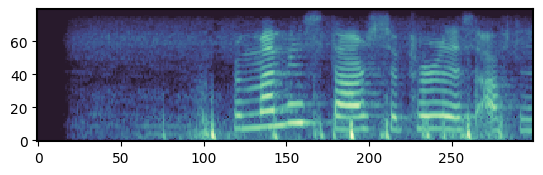

In [17]:
plt.imshow(x.cpu().numpy())
plt.show()

#### Prosodic Features

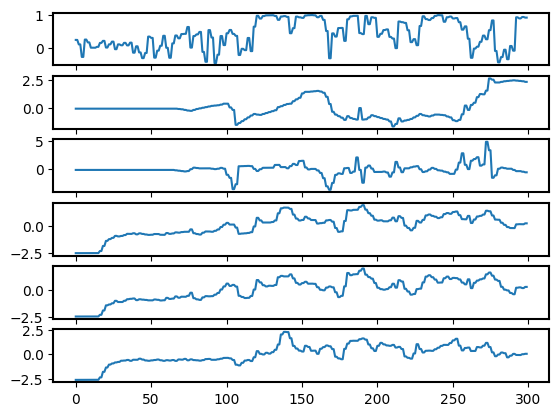

In [31]:
f, ax = plt.subplots(6,1) 

ax[0].plot(p[:, 0].repeat_interleave(2))
ax[1].plot(p[:, 1].repeat_interleave(2))
ax[2].plot(p[:, 2].repeat_interleave(2))
ax[3].plot(p[:, 3].repeat_interleave(2))
ax[4].plot(p[:, 4].repeat_interleave(2))
ax[5].plot(p[:, 5].repeat_interleave(2))
plt.show()

#### Audio

In [19]:
IPython.display.Audio(audio_path)

# Prosody-Attention

In [20]:
model = ProsodyAttentionTrainer.load_from_checkpoint("/root/Speech2Intent/paper_exp_final/checkpoints/slurp-1-prosody_attn=1-epoch=epoch=03.ckpt.ckpt")
_ = model.cuda().eval()

attn = model(x.unsqueeze(0).cuda(), p.unsqueeze(0).cuda())[1].detach().cpu().view(-1).repeat_interleave(2)
attn_numpy = attn.numpy()

### Attention Map of the Acoustic Encoder in Prosody-Attention

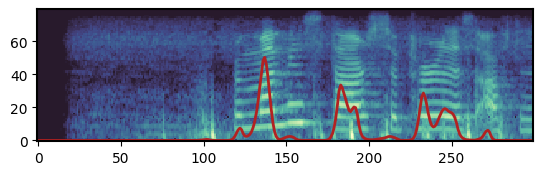

In [21]:
attn_smooth = smooth(attn)
fig, ax = plt.subplots()
ax.imshow(x.cpu().numpy())
ax.plot(attn_smooth*80*8, color='firebrick', linewidth=2)
plt.show()

# Prosody-Distillation

In [22]:
model = ProsodyDistillationTrainer.load_from_checkpoint("/root/Speech2Intent/paper_exp_final/checkpoints/slurp-1-prosody_dist=3-epoch=epoch=07.ckpt.ckpt")
_= model.cuda().eval()

z = model(x.unsqueeze(0).cuda(), p.unsqueeze(0).cuda())

p_attn = z[-1].detach().cpu().view(-1).repeat_interleave(2)
z_attn = z[-2].detach().cpu().view(-1).repeat_interleave(2)

### Attention Map of the Prosody Encoder in Prosody-Distillation

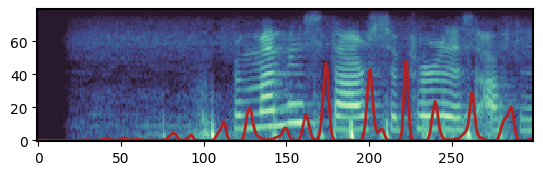

In [23]:
fig, ax = plt.subplots()
ax.imshow(x.cpu().numpy())
ax.plot(smooth(p_attn)*80*8, color='firebrick', linewidth=2)
plt.show()

### Attention Map of the Acoustic Encoder in Prosody-Distillation

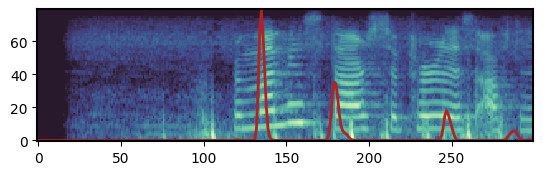

In [26]:
fig, ax = plt.subplots()
ax.imshow(x.cpu().numpy())
ax.plot(smooth(z_attn)*80*4, color='firebrick', linewidth=2)
plt.show()